In [1]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '/opt/ml/input/data/'
#train = pd.read_csv(path + 'train_data.csv')
train = pd.read_csv(path + 'FE/FE_solve_time_train.csv')
#test = pd.read_csv(path + 'test_data.csv')
test = pd.read_csv(path + 'FE/FE_solve_time_test.csv')

In [2]:
# train, test 병합. 모든 데이터 활용하기.
dat = pd.concat([train, test], axis = 0)
dat = dat.sort_values(by = ['userID', 'Timestamp'])

# 시험 난이도(?)로 추청되는 특성 따로 분류
dat['b_category'] = dat['assessmentItemID'].str[2]
# 시험지로 추청되는 특성 따로 분류. 뒤에 것이 좋을 것 같은데 일단 제출을 한 것으로 써놓음.
dat['test_category'] = dat['assessmentItemID'].str[4:7] # dat['assessmentItemID'].str[2] + dat['assessmentItemID'].str[4:7]

# answerCode이 -1로 되어있는 문제를 맞추기 위해 사용.
_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] < 0]

In [3]:
# 유저 마다 가장 마지막 문제를 맞추는 것을 기준으로 평가 하려함
# test 유저에 경우 가장 마지막 문제 전 문제를 맞추는 것을 기준으로 평가함.
user_final_time = _train.groupby('userID')['Timestamp'].max()
_train['train_valid'] = _train.apply(lambda x : -1 if x.Timestamp == user_final_time[x.userID] else x['answerCode'], axis = 1)
_valid = _train[_train['train_valid'] < 0]
_train = _train[_train['train_valid'] >= 0]

In [ ]:
# 모델에 적용하기 전 기본적인 데이터 전처리 부분
## 라벨링, 필요없는 칼럼 제거
_train_value = _train['answerCode']
_train.drop(['Timestamp', 'testId', 'train_valid', 'answerCode','quarter','weekday','dayofyear','week','year','hour','minute'], axis = 1, inplace = True)

_valid_value = _valid['answerCode']
_valid.drop(['Timestamp', 'testId', 'train_valid', 'answerCode','quarter','weekday','dayofyear','week','year','hour','minute'], axis = 1, inplace = True)

_test.drop(['Timestamp', 'testId', 'answerCode','quarter','weekday','dayofyear','week','year','hour','minute'], axis = 1, inplace = True)

# CatBoost에 적용하기 위해선 문자열 데이터로 변환 필요.
_train['userID'] = _train['userID'].astype('str')
_train['KnowledgeTag'] = _train['KnowledgeTag'].astype('str')

_valid['userID'] = _valid['userID'].astype('str')
_valid['KnowledgeTag'] = _valid['KnowledgeTag'].astype('str')

_test['userID'] = _test['userID'].astype('str')
_test['KnowledgeTag'] = _test['KnowledgeTag'].astype('str')

In [ ]:
_test['solve_time'] = _test['solve_time'].fillna(0)
_test['solve_time'] = _test['solve_time'].astype(int)

_test

,userID,assessmentItemID,KnowledgeTag,solve_time,b_category,test_category
1035,3,A050133008,5289,0,5,133
1706,4,A070146008,9080,0,7,146
3023,13,A070111008,9660,0,7,111
4283,17,A090064006,2611,0,9,064
4670,26,A060135007,1422,0,6,135
...,...,...,...,...,...,...
260052,7395,A040122005,10615,0,4,122
260067,7404,A030111005,7636,0,3,111
260082,7416,A050193004,10402,0,5,193
260097,7417,A050193004,10402,0,5,193


In [ ]:
_train['solve_time'] = _train['solve_time'].fillna(0)
_train['solve_time'] = _train['solve_time'].astype('int')
_valid['solve_time'] = _valid['solve_time'].fillna(0)
_valid['solve_time'] = _valid['solve_time'].astype('int')
print(_train.head())

  userID assessmentItemID KnowledgeTag  solve_time b_category test_category
0      0       A060001001         7224           0          6           001
1      0       A060001002         7225           3          6           001
2      0       A060001003         7225           8          6           001
3      0       A060001004         7225           7          6           001
4      0       A060001005         7225           7          6           001


In [ ]:
#!pip install catboost
# 가상환경에 패키지 설치 필요할듯
from catboost import CatBoostClassifier

# 하이퍼파라미터 수정할 여지가 많으니 추가나 수정하고 싶은 사람 수정해도 괜찮을듯.
# 일단 지난번에 사용했던 파라미터들 주석으로 들고 옴. 참고하면서 공부하면 좋을듯.

# params_cat = {
#     "task_type" : "GPU",
#     "devices" : '0',
#     "random_state": SEED,
#     'learning_rate': 0.04574578205475402, 
#     'bagging_temperature': 0.12172958098369972, 
#     'n_estimators': 2000, 
#     'max_depth': 8, 
#     'random_strength': 28, 
#     'l2_leaf_reg': 1.6285455533915874e-05, 
#     'min_child_samples': 18, 
#     'max_bin': 441, 
#     'od_type': 'Iter',
#     "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
# }

# model = CatBoostRegressor(**params_cat)

# 실제 적용한 모델은 learning_rate, iterations(=n_estimators, 아마도?)만 사용함.
cat_model = CatBoostClassifier(learning_rate=0.05, iterations=1000, task_type="GPU")
cat_model.fit(_train, _train_value, early_stopping_rounds=100, cat_features=list(_train.columns) ,verbose=500)


0:	learn: 0.6742521	total: 69.2ms	remaining: 1m 9s
500:	learn: 0.4506791	total: 38.6s	remaining: 38.5s
999:	learn: 0.4485331	total: 1m 15s	remaining: 0us


In [ ]:
# valid score를 확인해봄.
# 모델 환경상 test score보다 떨어질 수도. (토론 필요)
# 실제 제출한 test score은 auc는 0.7864, acc는 0.7124
from sklearn.metrics import accuracy_score, roc_auc_score

_valid_pred = cat_model.predict_proba(_valid)[:,1]
print(roc_auc_score(_valid_value, _valid_pred)) # auc
print(accuracy_score(_valid_value, np.where(_valid_pred >= 0.5, 1, 0))) # acc, 정확도

0.8304966498342403
0.7529411764705882


Text(0.5, 1.0, 'Feature Importance')

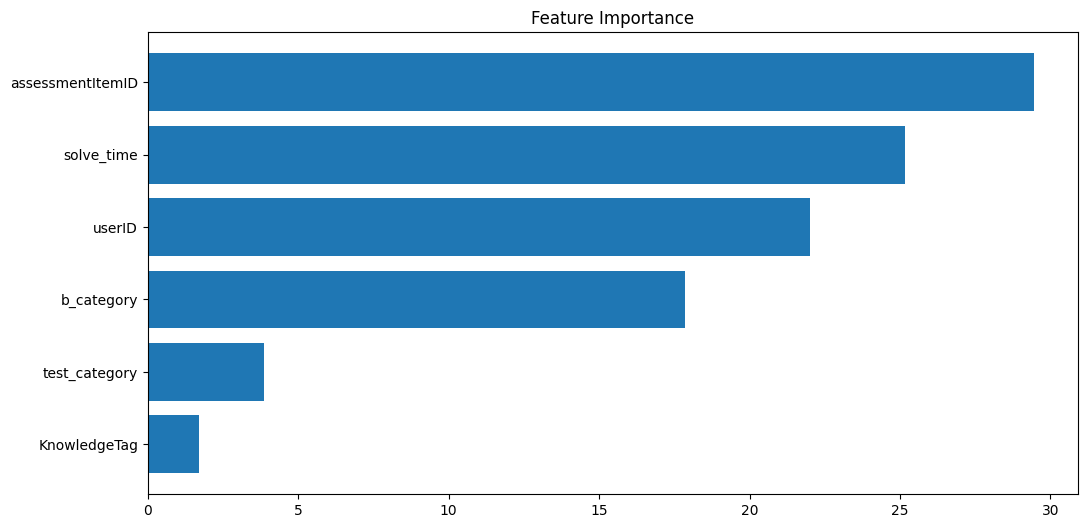

In [ ]:
import matplotlib as plt

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.pyplot.figure(figsize=(12, 6))
plt.pyplot.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.pyplot.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
plt.pyplot.title("Feature Importance")

In [ ]:
# submission 제출하기 위한 코드

_test_pred = cat_model.predict_proba(_test)[:,1]
_test['prediction'] = _test_pred
submission = _test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('./output/cat_submission_solvetime.csv', index = False)